# Data Visualisation

## Objectives

- Explored and highlighted differences between average healthy and powdery mildew cherry leaves.
- Create image montages for each class (healthy and powdery mildew).

## Inputs

- inputs/datasets/cherry-leaves/test
- inputs/datasets/cherry-leaves/train
- inputs/datasets/cherry-leaves/validation

## Outputs

- Image shape embeddings pickle file.
- Mean and variability of images per label plot.
- Plot to distinguish the contrast between parasite-contained and uninfected cell images.
- Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

---

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Set Data Directory


In [2]:
cwd= os.getcwd()
cwd

'/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks'

In [3]:
os.chdir('/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves/')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves'

### Set input directories

Set train, validation and test paths.

In [5]:
data_dir = 'inputs/datasets/cherry-leaves'
train_path = data_dir + '/train'
val_path = data_dir + '/validation'
test_path = data_dir + '/test'

print('Train path: ', train_path,'\n' 'Validation path: ', val_path,'\n' 'Test path: ', test_path)

Train path:  inputs/datasets/cherry-leaves/train 
Validation path:  inputs/datasets/cherry-leaves/validation 
Test path:  inputs/datasets/cherry-leaves/test


### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Set label names

In [7]:
labels = [label for label in os.listdir(train_path) if not label.startswith('.')]
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


---

# Data visualisation of image data

Compute average images size on train set.

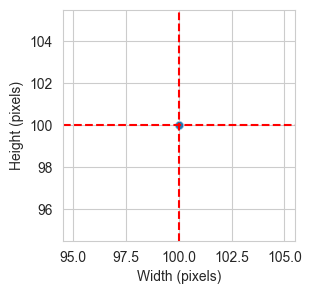

Width average: 100 
Height average: 100


In [8]:
width, height = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        width.append(d1)
        height.append(d2)

sns.set_style("whitegrid")
fig, axes = plt.subplots(figsize=(3, 3))
sns.scatterplot(x=height, y=width, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
width_mean = int(np.array(width).mean())
height_mean = int(np.array(height).mean())
axes.axvline(x=width_mean, color='r', linestyle='--')
axes.axhline(y=height_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {height_mean} \nHeight average: {width_mean}")

In [9]:
image_shape = (height_mean, width_mean, 3)
image_shape

(100, 100, 3)

Save the image shape embeddings to a pickle file.

In [11]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

## Average and variability of images per label

Function to load images in an array (tensor).
Images size for training the model is the average from all images in the train set.

In [12]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(data_dir, new_size=(100, 100), image_amount=20):
    image_list, label_list = np.array([], dtype='float32'), np.array([], dtype='object')    
    labels = os.listdir(data_dir)
    
    for label in labels:
        counter = 0
        label_path = os.path.join(data_dir, label)
        
        if not os.path.isdir(label_path):
            continue  # Skip if it's not a directory
            
        for image_filename in os.listdir(label_path):
            if counter < image_amount:
                img_path = os.path.join(label_path, image_filename)
                              
                img = image.load_img(path=img_path, target_size=new_size)
                img_array = image.img_to_array(img)
                
                # Normalize regardless of max pixel value
                img_resized = img_array / 255.0
                
                image_list = np.append(image_list, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                label_list = np.append(label_list, label)
                counter += 1      
    return image_list, label_list


/Users/simonpaske/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load image shapes and labels in an array

In [13]:
train_path = 'inputs/datasets/cherry-leaves/train'

image_shape = (100, 100, 3)

image_list, label_list = load_image_as_array(data_dir=train_path,
                                              new_size=image_shape,
                                              image_amount=30)
print(image_list.shape, label_list.shape)



(60, 100, 100, 3) (60,)


## Visual Inspection of the Data

### Plot and save mean and variability of images per label

In [14]:
from tensorflow.keras.preprocessing import image

def visualize_class_variability(data_dir, label_names, subset_size=5, save_images=False, file_path=None):
    for label in label_names:
        label_path = os.path.join(data_dir, label)

        if not os.path.isdir(label_path):
            continue  # Skip if it's not a directory

        images = []
        y_values = []  # Add a list to store corresponding labels
        for image_filename in os.listdir(label_path)[:subset_size]:
            img_path = os.path.join(label_path, image_filename)

            # Check if the path points to a file (not a directory)
            if os.path.isfile(img_path):
                img = image.load_img(path=img_path, target_size=(100, 100))  # Adjust target_size as needed
                img_array = image.img_to_array(img)
                images.append(img_array)
                y_values.append(label)  # Store the label for each image

        images = np.array(images)
        y_values = np.array(y_values).reshape(-1, 1, 1)  # Reshape y_values
        boolean_mask = np.any(y_values == label, axis=1).reshape(-1)  # Create boolean mask

        # Apply boolean mask to filter images
        images_filtered = images[boolean_mask]

        if images_filtered.shape[0] == 0:
            print(f"No images for label {label}")
            continue  # Skip if there are no images for the current label

        mean_image = np.mean(images_filtered, axis=0)
        std_image = np.std(images_filtered, axis=0)

        # Display mean image and standard deviation image
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(mean_image.astype(np.uint8))
        axes[0].set_title(f'Mean Image - {label}', fontsize=16)  # Increase title font size
        axes[1].imshow(std_image.astype(np.uint8))
        axes[1].set_title(f'Standard Deviation - {label}', fontsize=16)  # Increase title font size
        axes[2].axis('off')  # Placeholder for individual examples

        # Display individual images from the subset
        axes[2].set_title(f'Example Images - {label}', fontsize=16)  # Increase title font size
        for i in range(subset_size):
            axes[2].imshow(images[i].astype(np.uint8))
            axes[2].axis('off')
            axes[2].set_title(f'Example Images - {label}', fontsize=16)  # Increase title font size

        # Save or display the figure based on the flag
        if save_images:
            if file_path:
                plt.savefig(f"{file_path}/avg_var_{label}.png",
                            bbox_inches='tight', dpi=150)
            else:
                print("Error: file_path is not specified. Images will be displayed instead.")
                plt.tight_layout()
                plt.show()
        else:
            plt.tight_layout()
            plt.show()
            print("\n")


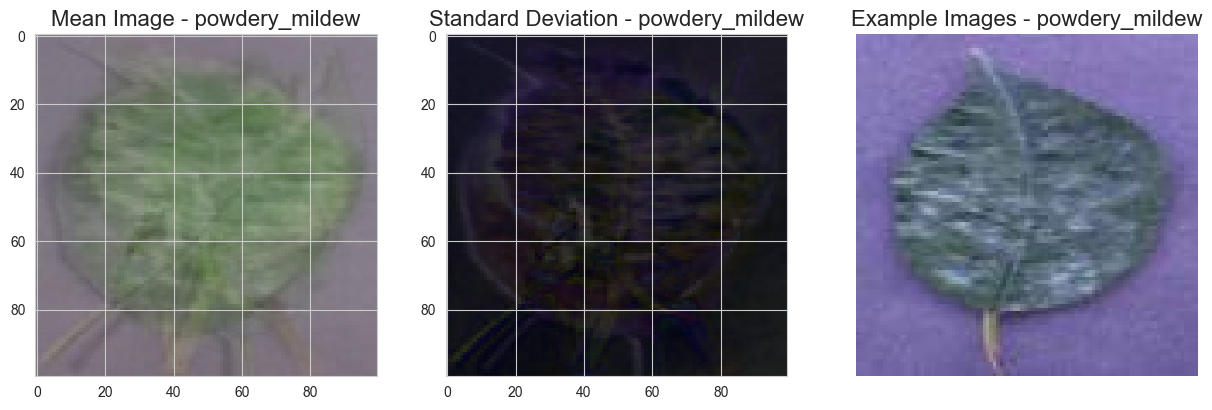

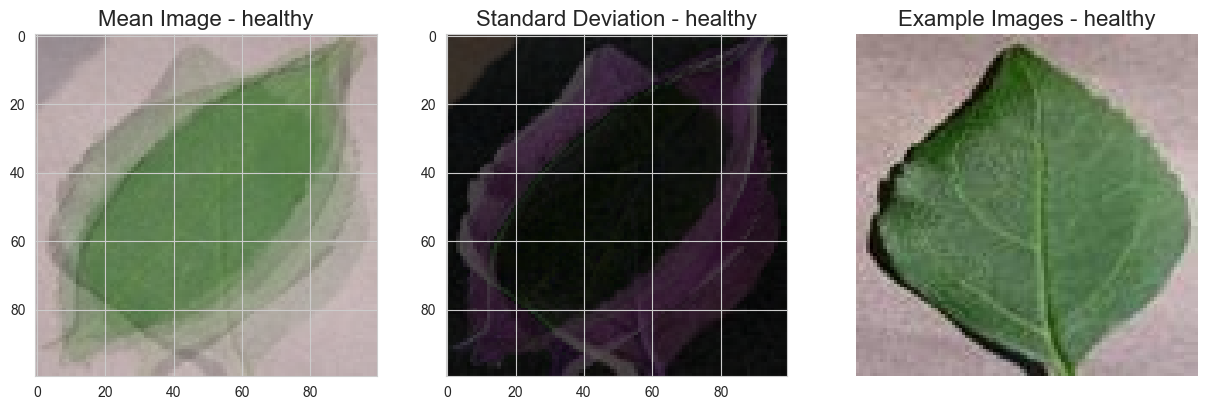

In [15]:
data_dir = 'inputs/datasets/cherry-leaves/train'
label_names = os.listdir(data_dir)
subset_size = 5

file_path = "outputs/v1"

visualize_class_variability(data_dir, label_names, save_images=True, file_path=file_path)

### Difference between average healthy and average powsery mildew images

In [16]:
from tensorflow.keras.preprocessing import image

def calculate_class_difference(data_dir, label_names, target_size=(100, 100), subset_size=5):
    healthy_images = []
    powdery_mildew_images = []

    for label in label_names:
        label_path = os.path.join(data_dir, label)

        if not os.path.isdir(label_path):
            continue  # Skip if it's not a directory

        images = []
        for image_filename in os.listdir(label_path)[:subset_size]:
            img_path = os.path.join(label_path, image_filename)

            # Check if the path points to a file (not a directory)
            if os.path.isfile(img_path):
                img = image.load_img(path=img_path, target_size=target_size)
                img_array = image.img_to_array(img)
                images.append(img_array)

        images = np.array(images)

        if label == 'healthy':
            healthy_images.extend(images)
        elif label == 'powdery_mildew':
            powdery_mildew_images.extend(images)

    healthy_images = np.array(healthy_images)
    powdery_mildew_images = np.array(powdery_mildew_images)

    if healthy_images.shape[0] == 0 or powdery_mildew_images.shape[0] == 0:
        print("Not enough images for one or both classes.")
        return None

    avg_healthy = np.mean(healthy_images, axis=0)
    avg_powdery_mildew = np.mean(powdery_mildew_images, axis=0)

    difference = np.abs(avg_healthy - avg_powdery_mildew)

    return avg_healthy, avg_powdery_mildew, difference

def plot_images_horizontally(images, titles, save_path=None):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

    for i in range(num_images):
        axes[i].imshow(images[i].astype(np.uint8))
        axes[i].set_title(titles[i], fontsize=16)
        axes[i].axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Figure saved to: {save_path}")
    else:
        plt.show()


#### Plot and save the difference between average healthy and average powsery mildew images

Figure saved to: outputs/v1/difference_plot.png


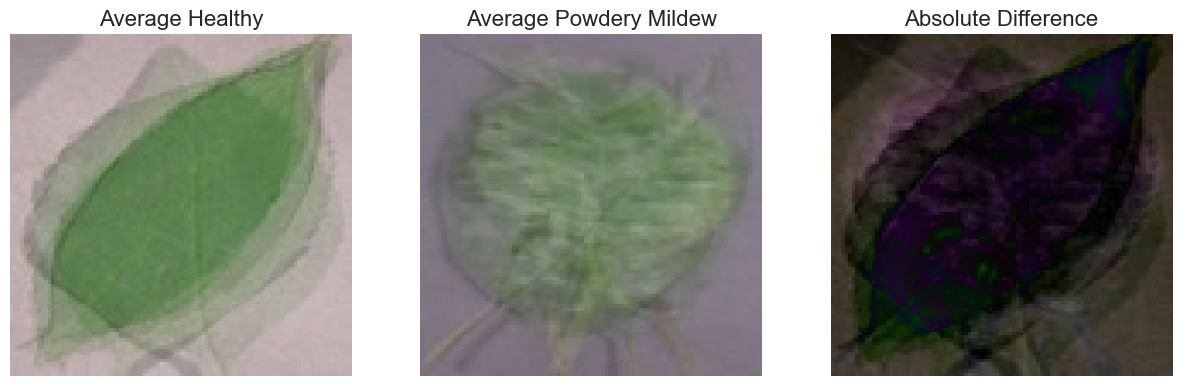

In [17]:
result = calculate_class_difference(data_dir, label_names, target_size=(100, 100), subset_size=subset_size)

if result:
    avg_healthy, avg_powdery_mildew, difference = result

    # Save the figure with the specified file_path
    save_path = "outputs/v1/difference_plot.png"
    
    # Display the average healthy image, average powdery mildew image, and the absolute difference horizontally
    plot_images_horizontally([avg_healthy, avg_powdery_mildew, difference],
                             ["Average Healthy", "Average Powdery Mildew", "Absolute Difference"],
                             save_path)


---

## Image Montage

In [18]:
import itertools
import random
sns.set_style("white")


def image_montage(data_dir, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(data_dir)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(data_dir + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(data_dir + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

Run Montage in all labels



powdery_mildew


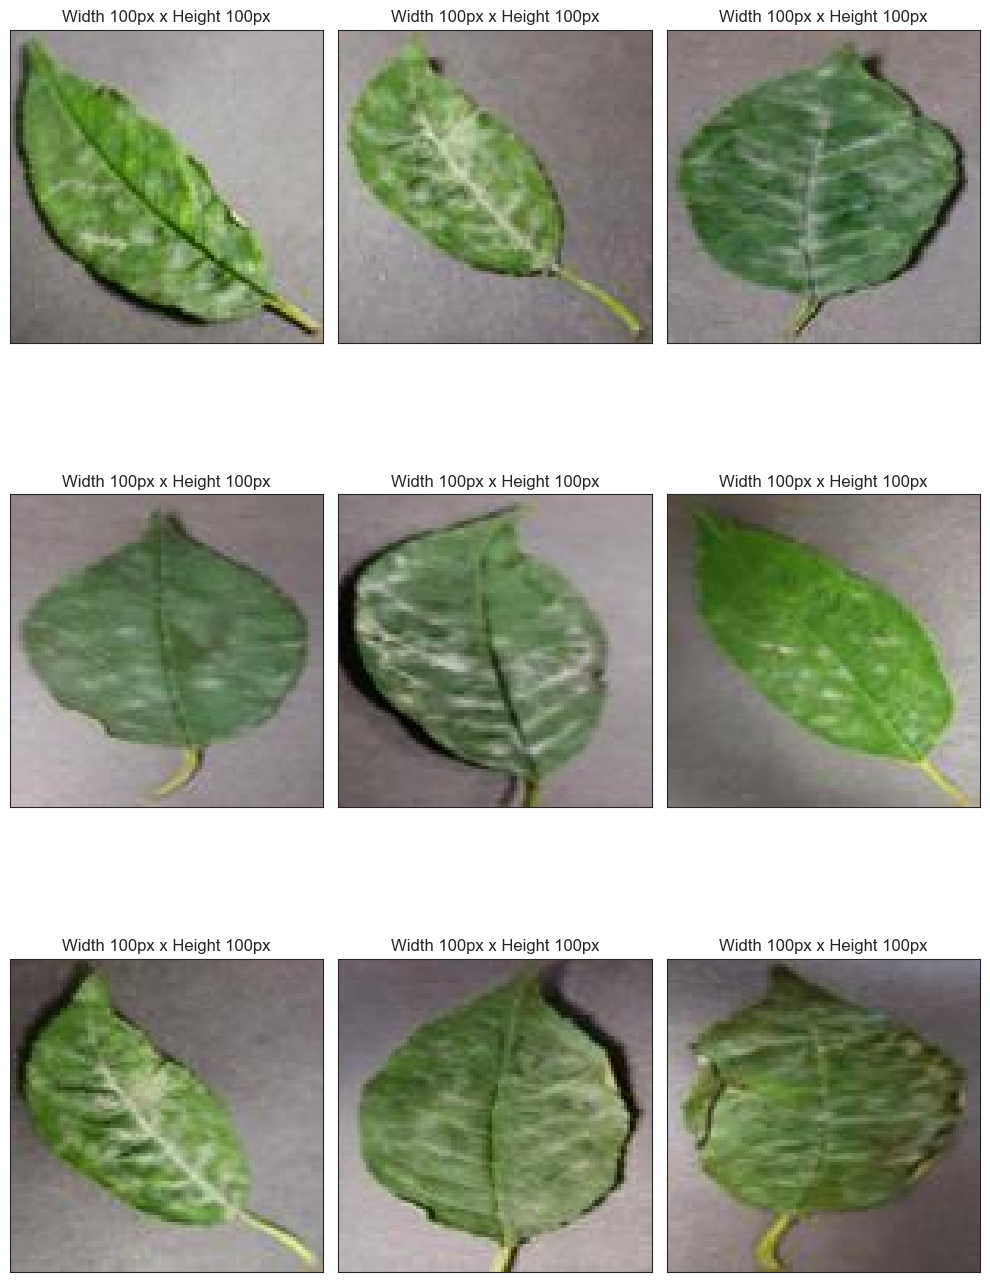





healthy


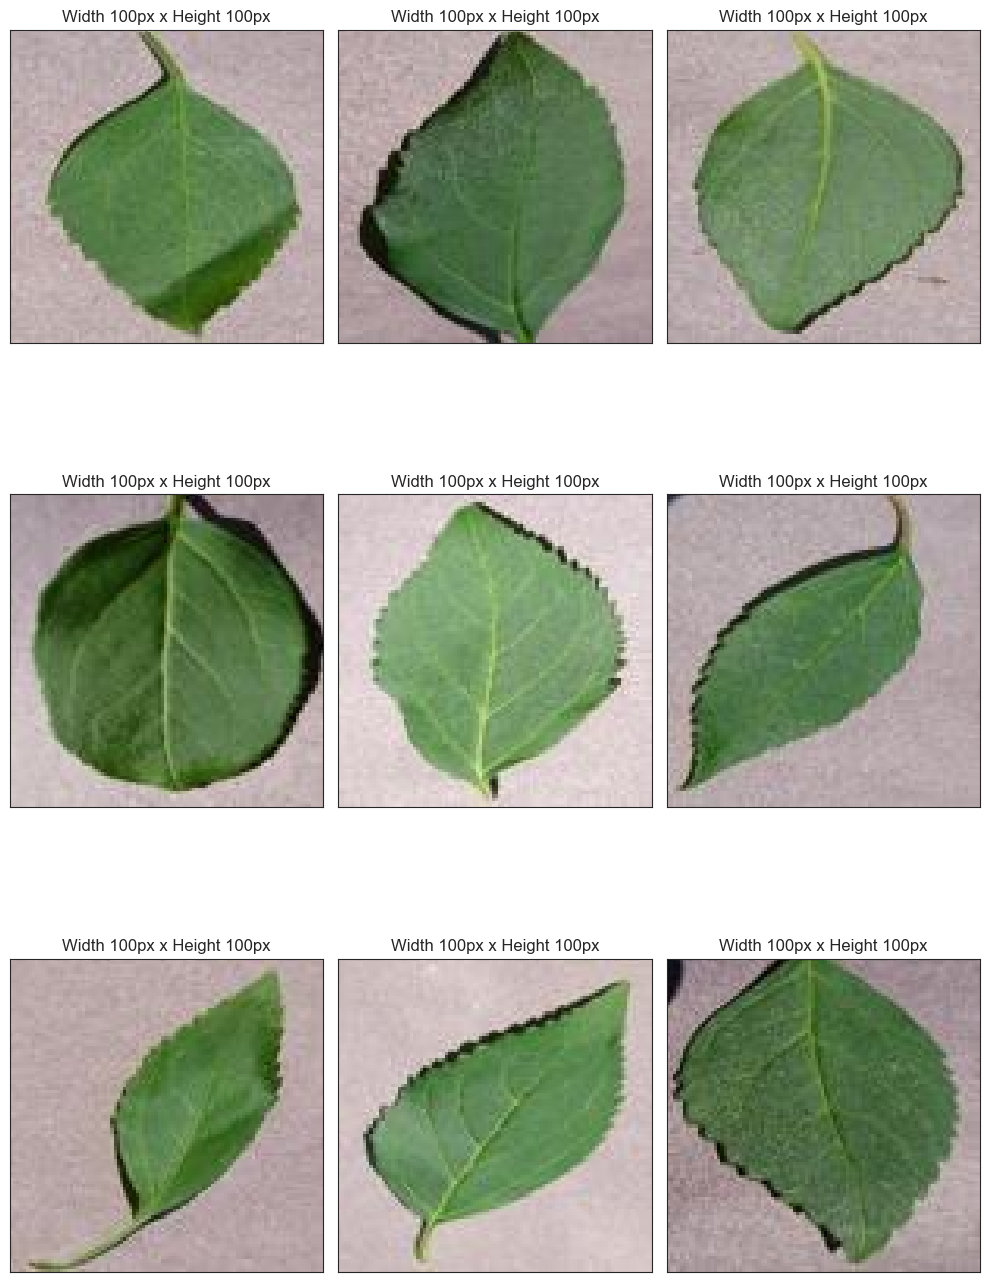

In [19]:
for label in labels:
    print("\n")
    print(label)
    image_montage(data_dir=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---

### Image distribution per label

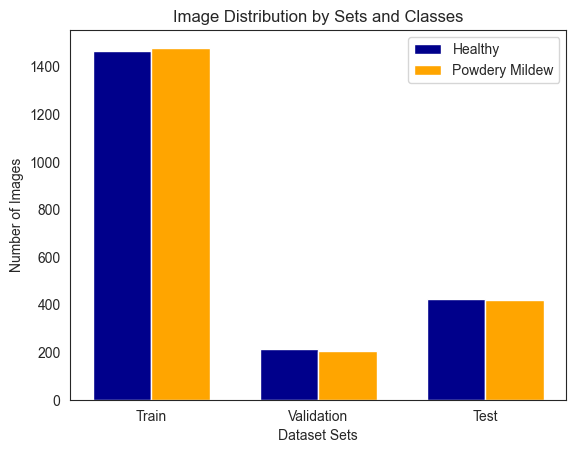

Train images: {'healthy': 1466, 'powdery_mildew': 1479}
Validation images: {'healthy': 215, 'powdery_mildew': 205}
Test images: {'healthy': 423, 'powdery_mildew': 420}


In [20]:
import os
import matplotlib.pyplot as plt

def count_images_by_class(folder_path, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        class_counts[class_name] = sum([len(files) for _, _, files in os.walk(class_path) if any(file.lower().endswith(('.jpg', '.jpeg', '.png')) for file in files)])
    return class_counts

data_dir = 'inputs/datasets/cherry-leaves'
class_names = ['healthy', 'powdery_mildew']

train_path = data_dir + '/train'
val_path = data_dir + '/validation'
test_path = data_dir + '/test'

train_images_count = count_images_by_class(train_path, class_names)
val_images_count = count_images_by_class(val_path, class_names)
test_images_count = count_images_by_class(test_path, class_names)

# Plotting
sets = ['Train', 'Validation', 'Test']

healthy_counts = [train_images_count['healthy'], val_images_count['healthy'], test_images_count['healthy']]
mildew_counts = [train_images_count['powdery_mildew'], val_images_count['powdery_mildew'], test_images_count['powdery_mildew']]

bar_width = 0.35
index = range(len(sets))

plt.bar(index, healthy_counts, bar_width, label='Healthy', color='darkblue')
plt.bar([i + bar_width for i in index], mildew_counts, bar_width, label='Powdery Mildew', color='orange')

plt.xlabel('Dataset Sets')
plt.ylabel('Number of Images')
plt.title('Image Distribution by Sets and Classes')
plt.xticks([i + bar_width / 2 for i in index], sets)
plt.legend()
plt.show()

print("Train images:", train_images_count)
print("Validation images:", val_images_count)
print("Test images:", test_images_count)
